# 作業 : (Kaggle)鐵達尼生存預測
https://www.kaggle.com/c/titanic

# [作業目標]
- 試著調整特徵篩選的門檻值, 觀察會有什麼影響效果

# [作業重點]
- 調整相關係數過濾法的篩選門檻, 看看篩選結果的影響 (In[5]~In[8], Out[5]~Out[8])
- 調整L1 嵌入法篩選門檻, 看看篩選結果的影響 (In[9]~In[11], Out[9]~Out[11])

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

data_path = '../data/Part02/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId'], axis=1)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


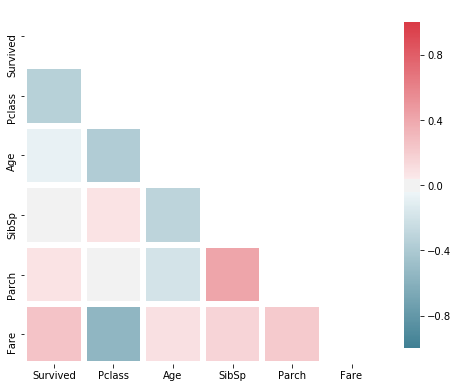

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

corr = df.corr()

# generate a mask for upper triangle
# 筆記：np.zeros_like() 是 Return an array of zeros with the same shape and type as a given array.
# 參考資料：https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros_like.html
mask = np.zeros_like(corr, dtype=np.bool)

# 筆記：np.triu_indices_from() 是 Return the indices for the upper-triangle of arr.
# 參考資料：https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.triu_indices_from.html
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
# 筆記：分別設定figure和ax的尺寸為8和10
# 參考資料：https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplots.html
fig, ax = plt.subplots(figsize=(8,12))

# Generate a custom diverging colormap
# sns.diverging_palette()的用法：https://seaborn.pydata.org/generated/seaborn.diverging_palette.html
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, vmin=-1, vmax=1, mask=mask, cmap=cmap, center=0, 
           square=True, linewidths=5, cbar_kws={"shrink": .5})
# 筆記：
# center=0  設定熱圖的中心值是0。
# square=True  設定繪製出的圖是方形的。
# linewidths =1  設定各個熱點之間 線的粗細。
# cbar_kws={"shrink": .5}}  設定熱圖 圖例 的縮放比例。

plt.show()

In [3]:
# 記得刪除 Survived
df = df.drop(['Survived'], axis=1)

#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(-1)
df.head()

5 Numeric Features : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']



,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


# 作業1
* 鐵達尼生存率預測中，試著變更兩種以上的相關係數門檻值，觀察預測能力是否提升?

In [4]:
# MinMaxScaler()初始化
MMEncoder = MinMaxScaler()

# 訂定cross_val_score 用到的 estimator
estimator = LogisticRegression(solver='lbfgs')

In [5]:
# 原始特徵 + 邏輯斯迴歸
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.7004864906462793

In [6]:
# 篩選相關係數1
"""
Your Code Here
"""
high_list = list(corr[(corr['Survived']>0.08) | (corr['Survived']<-0.08)].index)
high_list.pop(0)
print(high_list)

['Pclass', 'Parch', 'Fare']


In [7]:
# 特徵1 + 邏輯斯迴歸
# 結果下降
train_X = MMEncoder.fit_transform(df[high_list])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.6847684949253259

In [8]:
# 篩選相關係數2
"""
Your Code Here
"""
high_list = list(corr[(corr['Survived']>0.1) | (corr['Survived']<-0.1)].index)
high_list.pop(0)
print(high_list)

['Pclass', 'Fare']


In [9]:
# 特徵2 + 邏輯斯迴歸
# 結果下降
train_X = MMEncoder.fit_transform(df[high_list])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.6791567235397566

# 作業2
* 續上題，使用 L1 Embedding 做特徵選擇(自訂門檻)，觀察預測能力是否提升?

In [10]:
from sklearn.linear_model import Lasso
"""
Your Code Here, select parameter alpha 
"""
L1_Reg = Lasso(alpha=0.003)

train_X = MMEncoder.fit_transform(df)
L1_Reg.fit(train_X, train_Y)
L1_Reg.coef_

array([-0.4116012 , -0.18850803, -0.        ,  0.13666287,  0.01405623])

In [11]:
from itertools import compress
L1_mask = list((L1_Reg.coef_>0) | (L1_Reg.coef_<0))
L1_list = list(compress(list(df), list(L1_mask)))
L1_list

['Pclass', 'Age', 'Parch', 'Fare']

In [12]:
# L1_Embedding 特徵 + 線性迴歸
# 結果：些微提升。
train_X = MMEncoder.fit_transform(df[L1_list])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.7038572771631333

## 以下是筆記：

In [13]:
a = corr[(corr['Survived']>0.1) | (corr['Survived']<-0.1)]
print(a)
type(a)

          Survived    Pclass       Age     SibSp     Parch      Fare
Survived  1.000000 -0.338481 -0.077221 -0.035322  0.081629  0.257307
Pclass   -0.338481  1.000000 -0.369226  0.083081  0.018443 -0.549500
Fare      0.257307 -0.549500  0.096067  0.159651  0.216225  1.000000


pandas.core.frame.DataFrame

In [14]:
# pandas.DataFrame.index 是返回 The index (row labels) of the DataFrame.
b = corr[(corr['Survived']>0.1) | (corr['Survived']<-0.1)].index
print(b)
type(b)

Index(['Survived', 'Pclass', 'Fare'], dtype='object')


pandas.core.indexes.base.Index